# LIGHT GBM CLASSIFIER - TEST

In [1]:
import numpy as np
from sklearn import datasets
import lightgbm as lgb
import pandas as pd
from datetime import datetime
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import seaborn as sns
from sklearn.metrics import auc

### FUNCTIONS

In [2]:
def plot_roc_curve(true_labels, scores):
    ### actual code for roc + threshold charts start here 
    # compute fpr, tpr, thresholds and roc_auc
    fpr, tpr, thresholds = roc_curve(true_labels, scores)
    roc_auc = auc(fpr, tpr) # compute area under the curve

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")

    # create the axis of thresholds (scores)
    ax2 = plt.gca().twinx()
    ax2.plot(fpr, thresholds, markeredgecolor='r',linestyle='dashed', color='r')
    ax2.set_ylabel('Threshold',color='r')
    ax2.set_ylim([thresholds[-1],thresholds[0]])
    ax2.set_xlim([fpr[0],fpr[-1]])

    plt.show()
    
    pass

In [3]:
def plot_score_dist(y_true, y_score):
    
    df = pd.DataFrame(data=np.column_stack((y_true, y_score)), columns=['target','score'])
    
    plt.figure(figsize=(7, 4))
    ax = sns.boxplot(x="target", y="score", data=df)
    ax.set_title("Score distribution")

    pass

In [4]:
def plot_importance(booster, figsize=(10,5), feature_names=None, **kwargs): 
    
    fig, ax = plt.subplots(1,1,figsize=figsize) 
    
    if feature_names:
        mapper = {'f{0}'.format(i): v for i, v in enumerate(feature_names)}
        mapped = {mapper[k]: v for k, v in booster.get_fscore().items()}
        return xgb.plot_importance(mapped, ax=ax, **kwargs)
    else:
        return xgb.plot_importance(booster=booster, ax=ax, **kwargs)
    pass

### GLOBAL VARIABLES

In [5]:
DATAPATH = 'data/train_test/'
SEED = 47
NITER = 100
CV = 5
SCORE = 'roc_auc'
usenull = True
NJOBS = -1

### LOAD DATA

In [6]:
X_train =  pd.read_pickle(DATAPATH+'X_train.pkl')

In [7]:
X_test =  pd.read_pickle(DATAPATH+'X_test.pkl')

In [8]:
y_train =  pd.read_pickle(DATAPATH+'y_train.pkl')['target']

In [46]:
y_test =  pd.read_pickle(DATAPATH+'y_test.pkl')

In [10]:
features_eng = np.load('data/train_test/features_selected.npy')

In [11]:
X_train = X_train[features_eng]

In [12]:
X_test = X_test[features_eng]

In [13]:
# create dataset for lightgbm
lgb_train = lgb.Dataset(data=X_train, label=y_train)

In [14]:
lgb_test = lgb.Dataset(X_test)

### TRAIN MODEL

In [19]:
# ======== General Parameters ======= #

# Select the type of model to run at each iteration. gbtree or gblinear.
boosting = 'gbdt'


# ======== Booster Parameters ======== # 

# Analogous to learning rate in GBM. 
# Typical final values to be used: 0.01-0.2
eta = 0.01 


# A node is split only when the resulting split gives a positive reduction in the loss function. 
# Gamma specifies the minimum loss reduction required to make a split.
gamma = [i/10.0 for i in range(0,5)]


# Control the balance of positive and negative weights, useful for unbalanced classes. 
# A typical value to consider: sum(negative instances) / sum(positive instances)scale_pos_weight = 1
scale_pos_weight = (len(y_train) - sum(y_train))/sum(y_train)


# Learning Task Parameters
# This defines the loss function to be minimized. See documentation
# -  options: regression, regression_l1, huber, fair, poisson, quantile, 
# mape, gamma, tweedie, binary, multiclass, multiclassova, cross_entropy, cross_entropy_lambda,
# lambdarank, aliases: objective_type, app, application
objective  = 'binary'


# The metric to be used for validation data.
# - rmse, root square loss, aliases: root_mean_squared_error, l2_root
# - quantile, Quantile regression
# - mape, MAPE loss, aliases: mean_absolute_percentage_error
# - huber, Huber loss
# - fair, Fair loss
# - poisson, negative log-likelihood for Poisson regression
# - gamma, negative log-likelihood for Gamma regression
# - gamma_deviance, residual deviance for Gamma regression
# - tweedie, negative log-likelihood for Tweedie regression
# - ndcg, NDCG, aliases: lambdarank
# - map, MAP, aliases: mean_average_precision
# - auc, AUC
# - binary_logloss, log loss, aliases: binary
metric = 'auc'

In [29]:
model_param = np.load('output/models/bayesianoptcv_gbm_classifier_bestparams_d2019-11-28.npy',allow_pickle=True).tolist()

In [30]:
model_param['max_depth'] = int(np.round(model_param['max_depth'],0))
model_param['min_child_weight'] = int(np.round(model_param['min_child_weight'],0))


In [31]:
model_param['num_leaves'] = int(np.round(model_param['num_leaves'],0))


In [32]:
model_param['seed'] = SEED
model_param['booster'] = boosting
model_param['objective'] = objective
model_param['scale_pos_weight'] = scale_pos_weight


In [33]:
model_param['num_threads'] = NJOBS

In [34]:
model_param

{'bagging_fraction': 0.8327365806346091,
 'feature_fraction': 0.8881760200078465,
 'max_depth': 13,
 'min_child_weight': 30,
 'min_split_gain': 0.004145814603445978,
 'num_leaves': 99,
 'n_estimators': 344,
 'seed': 47,
 'booster': 'gbdt',
 'objective': 'binary',
 'scale_pos_weight': 9.22705413575158,
 'num_threads': -1}

In [35]:
lgbmodel = lgb.train(model_param, lgb_train)

/opt/anaconda3/envs/xgboostenv/lib/python3.7/site-packages/lightgbm/engine.py:118: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


In [36]:
y_pred = lgbmodel.predict(X_test)

### MODEL RESULT

In [37]:
print(SCORE, ' : ', roc_auc_score(y_test,y_pred))

roc_auc  :  0.7855243966891119


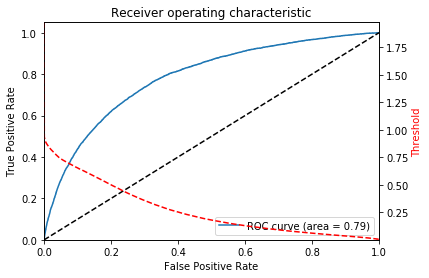

In [38]:
plot_roc_curve(y_test,y_pred)

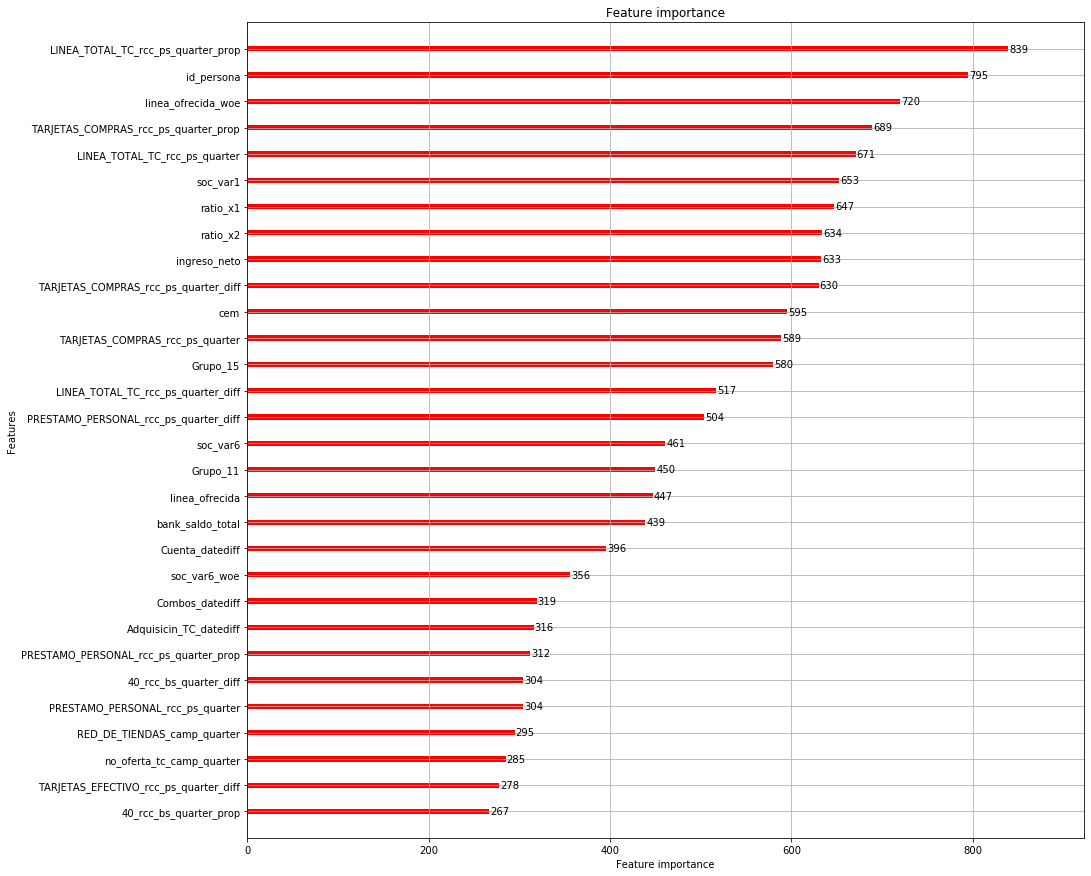

In [39]:
lgb.plot_importance(booster=lgbmodel, figsize=(15,15), max_num_features=30, color='red')
pass

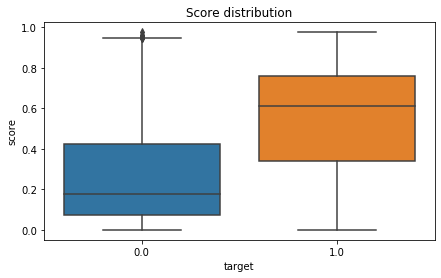

In [40]:
plot_score_dist(y_test, y_pred)

In [42]:
def find_optimal_cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.ix[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 

In [44]:
cutoff = find_optimal_cutoff(y_test, y_pred)
cutoff

/opt/anaconda3/envs/xgboostenv/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


[0.37907904013913635]

In [47]:
from scipy.optimize import differential_evolution

#res = test_labels.join(pd.concat(y_pred).rename("probs"))
optimization = differential_evolution(lambda c: -((y_pred > c[0]) * y_test.margen / y_test.margen.sum()).sum(), [(0, 1)])
optimization

     fun: -1.1204930316458284
 message: 'Optimization terminated successfully.'
    nfev: 77
     nit: 4
 success: True
       x: array([0.1715263])

In [45]:
y_test

prediction_id
163879_201903    0
34778_201904     0
207874_201904    1
12659_201904     0
53183_201904     0
149337_201901    0
97552_201901     0
41872_201903     0
73533_201904     0
192763_201904    0
164513_201901    0
164944_201901    0
223235_201902    0
191459_201903    0
252969_201904    0
116804_201901    1
160406_201901    0
17883_201902     0
215821_201902    0
125339_201904    0
68239_201903     0
6234_201903      0
40516_201904     0
143532_201901    0
213524_201902    0
242117_201902    0
71185_201904     1
6074_201904      0
135620_201903    0
17973_201902     0
                ..
226026_201901    0
103611_201904    0
162551_201901    0
228551_201904    0
242964_201903    0
143457_201903    1
130126_201903    0
219031_201904    1
182718_201903    0
75192_201904     0
254786_201901    0
144291_201903    0
108354_201904    0
116097_201904    0
103221_201901    0
220101_201904    0
39153_201901     0
32108_201904     0
157919_201902    0
115286_201901    0
169936_201901    